# **Анализ данных национального виктимизационного опроса**

# Данный проект посвящен изучению преступности на территории Российской Федерации. Цель работы – выяснить, как влияют социально-демографические характеристики человека на его возможность оказаться жертвой преступления (виктимность).
>##### Данные для анализа собраны Институтом проблем правоприменения (ИПП) при ЕУ СПб и представляют результаты телефонного опроса респондентов не моложе 18 лет на основании простой случайной выборки телефонных номеров. Респонденты опрашивались не зависимо от гражданства, но, по понятным причинам, большинство (98.1%) были гражданами РФ. Вопросы делились на анкетные (пол, возраст, социо-демографический профиль), основной («были ли жертвой преступления») и уточняющие вопросы о преступлениях (где, когда и т.п.). Анкета составлена специальным образом профессионалами, учитывая многие особенности, например специфику русского языка.
# Задачи данного исследования:
*   Ознакомиться с форматом данных, осуществить их предобработку.
*   Сделать анализ данных опроса жителей РФ о преступлениях, жертвами которых они становились.
*   Визуализировать найденные закономерности.
*   Исходя из выявленных зависимостей, построить классификационную модель, определяющую виктимность человека.





### Замечание: для корректного отображения графиков просьба произвести *запуск всех ячеек*

## Структура проекта



---


1.   [***Импорт необходимых библиотек***](#Импорт-необходимых-библиотек)
2.   [***Загрузка и предварительная обработка данных***](#Загрузка-и-предварительная-обработка-данных)
3.   [***Был ли респодент жертвой преступления?***](#Был-ли-респодент-жертвой-преступления?)
4.   [***Анализ влияния полового признака на совершение преступлений и подверженность им***](#Анализ-влияния-полового-признака-на-совершение-преступлений-и-подверженность-им)
5.   [***Был ли найден нападавший?***](#Был-ли-найден-нападавший?)
6.   [***Была ли необходима медицинская помощь?***](#Была-ли-необходима-медицинская-помощь?)
7.   [***Был ли нападавший при исполнении?***](#Был-ли-нападавший-при-исполнении?)
8.   [***Анализ частоты видов преступлений***](#Анализ-частоты-видов-преступлений)
9.   [***Анализ влияния возраста на подверженность преступлениям***](#Анализ-влияния-возраста-на-подверженность-преступлениям)
10.   [***Анализ влияния дохода на подверженность преступлениям***](#Анализ-влияния-дохода-на-подверженность-преступлениям)
11.   [***Анализ скорости реагирования правоохранителей***](#Анализ-скорости-реагирования-правоохранителей)
12.   [***Анализ материального ущерба пострадавших***](#Анализ-материального-ущерба-пострадавших)
13.   [***Анализ зависимости вида преступлений от времени суток***](#Анализ-зависимости-вида-преступлений-от-времени-суток)


---





## Импорт и установка необходимых библиотек

In [1]:
!pip install catboost
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install sklearn
!pip install tensorflow
!pip install scipy
!pip install ipywidgets
!pip install ipython
!pip install seaborn

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [3]:
#Импорт

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras.utils import get_file as getfile  # Используется для того, чтобы скачать датасет напрямую
import matplotlib.patches as mpatches
from scipy import stats as st
from copy import copy
import seaborn as sns
import math

## Загрузка и предварительная обработка данных

*После изучения данных и рекомендаций в [технической документации к данным](https://globaldataversecommunityconsortium.github.io/dataverse-previewers/previewers/PDFPreview.html?fileid=3441892&siteUrl=https://dataverse.harvard.edu&datasetid=3382060&datasetversion=5.0&locale=en), было принято решение использовать **только сконструированные переменные**, которые не несут в себе субъективных оценок респондента и являются необходимыми для анализа, добавив к ним переменные:*


*   **crime_asked_medical_help** – нуждалась ли жертва в оказании медицинской помощи (логическая переменная)

*   **offender_is_on_duty** – был ли преступник должностным лицом или при исполнении (логическая переменная)





**Загрузка файла с серверов Гарварда**

In [4]:
# Загрузка файла с серверов Гарварда
dataset_path = getfile("dataset.csv", "https://dataverse.harvard.edu/api/access/datafile/3676762?format=original&gbrecs=true")

Преобразовываем данные в датафрейм


In [5]:
raw_dataset = pd.read_csv(dataset_path)
df = raw_dataset.copy()

Добавляем указанные переменные, удаляем исходные переменные, оставляя только сконструированные

In [6]:
# Добавляем переменные
df['crime_asked_medical_help'] = df['Q28']
df['offender_is_on_duty'] = df['Q12']
df['interview_duration'] = df['IVDur']

# Удаляем исходные переменные
df.drop(df.iloc[:, :122], inplace=True, axis=1)

Удаляем сконструированные переменные, несущие в себе субъективные оценки корреспондента / не используемые в анализе

In [7]:
# Список удаляемых сконструированных переменных, несущих в себе субъективные оценки корреспондента / не используемых в анализе
drop_list = ['resp_place_is_city', 'resp_place_population',
         'resp_household_size', 'resp_is_enforcers_familiar',
         'resp_sample_group', 'resp_ses_is_pensioner', 
         'resp_ses_is_welfare', 'resp_ses_is_looked_for_job', 
         'resp_ses_job_is_manager', 'resp_ses_job_is_freelancer', 
         'resp_ses_job_is_manual', 'resp_ses_job_is_private', 
         'resp_ses_job_is_public', 'resp_ses_is_student', 
         'resp_ses_is_employed', 'crime_is_offender_seen', 
         'crime_place', 'crime_place_remote', 'crime_place_is_home', 
         'crime_is_people_around','victim_is_self_accuse', 
         'victim_damage_rub_ln', 'victim_is_repeat_contact_with_police', 
         'victim_police_number_of_contacts', 'victim_who_contacted_police',
         'victim_way_to_contact_police', 'victim_is_compensated', 
         'victim_is_reconciliation', 'victim_is_told_anyone', 
         'offender_is_alone','offender_is_familiar', 
         'offender_relationship'] 

df.drop(drop_list, axis=1, inplace=True) # Удаление переменных

# Расставляем столбцы в правильном порядке
cols =['interview_duration', 'resp_is_male', 'resp_age',
       'resp_is_living_alone', 'resp_is_married',
       'resp_income', 'resp_edu', 'resp_is_crime_record',
       'resp_is_russian_citizen', 'resp_is_crime_victim', 'resp_ses',
       'crime_season', 'crime_is_remote', 'crime_is_property_damage',
       'crime_is_violent_damage', 'crime_is_seeking_medical_help',
       'crime_asked_medical_help', 'crime_is_property_acquisition',
       'crime_is_fraud', 'crime_is_threat', 'crime_type',
       'crime_place_grouped', 'crime_is_daytime', 'victim_is_reporting',
       'victim_damage_physical', 'victim_damage_rub',
       'victim_is_crime_case_initiated', 'victim_police_reaction_time',
       'victim_is_offender_found', 'victim_who_found_offender',
       'victim_is_offender_punished', 'victim_is_went_to_court',
       'victim_compensation', 'offender_is_male', 'offender_is_on_duty',
       'offender_is_drug_intoxicated', 'offender_relationship_grouped']

df = df[cols]

Создаем переменные, содержащие цвета для последующего использования при построении графиков в едином стиле

In [8]:
colors = ['powderblue',
          'steelblue',
          'deepskyblue',
          'lightblue',
          'darkturquoise',
          'cadetblue',
          'teal']

pltclr = 'silver'
digclr = 'whitesmoke'

Проведем настройку библиотеки ***Pandas***, в частности отключим предупреждение о копировании данных

In [9]:
pd.options.mode.chained_assignment = None  # default='warn'

***Итоговый вид данных после исходной предобработки:***




In [10]:
df.head()

,interview_duration,resp_is_male,resp_age,resp_is_living_alone,resp_is_married,resp_income,resp_edu,resp_is_crime_record,resp_is_russian_citizen,resp_is_crime_victim,...,victim_police_reaction_time,victim_is_offender_found,victim_who_found_offender,victim_is_offender_punished,victim_is_went_to_court,victim_compensation,offender_is_male,offender_is_on_duty,offender_is_drug_intoxicated,offender_relationship_grouped
0,544,0,57,0.0,0.0,3.0,3.0,0.0,1.0,1,...,NaN,0.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
1,1643,0,59,0.0,1.0,NaN,3.0,0.0,1.0,1,...,1.0,1.0,1.0,0.0,0.0,4.0,1.0,NaN,0.0,6.0
2,676,0,35,0.0,1.0,NaN,3.0,0.0,1.0,1,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
3,510,0,22,1.0,0.0,3.0,3.0,0.0,1.0,1,...,1.0,0.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
4,1107,0,79,0.0,1.0,1.0,3.0,0.0,1.0,1,...,2.0,0.0,NaN,NaN,0.0,4.0,1.0,NaN,0.0,6.0


**Вывод:**
> Мы загрузили и предобработали данные согласно рекомендациям технической документации. Теперь мы можем приступить к анализу.

# Анализ данных

## Был ли респодент жертвой преступления?


Определим процентное отношение людей, которые являлись жертвами преступлений среди опрошенных.

Создадим функцию для замены номера категории на её название

In [11]:
def ifvictim(x):
  if x:
    return "Является"
  else:
    return "Не является"

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [12]:
resp_is_victim = df['resp_is_crime_victim'].dropna() \
                        .apply(ifvictim)

print("Выборка содержит", len(resp_is_victim), "строк")

Выборка содержит 16818 строк


Посчитаем процентное содержание каждой категории в выборке

In [13]:
resp_is_victim_count = resp_is_victim.value_counts(1).sort_values()

print("Является ли респондент жертвой преступления?")
for i in range(len(resp_is_victim_count)):
  print("{} - {:.3f}%".format(resp_is_victim_count.index[i],
                              resp_is_victim_count[i] * 100))

Является ли респондент жертвой преступления?
Является - 17.844%
Не является - 82.156%


Построим по полученным значениям диаграмму

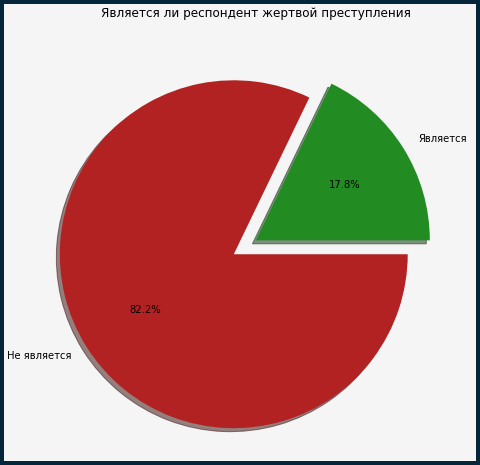

In [14]:
# Красивые графики
plt.figure(figsize=(12, 8), linewidth=8, edgecolor="#04253a").set_facecolor(digclr)
plt.pie(resp_is_victim_count.tolist(), labels=resp_is_victim_count.index,
        colors=('forestgreen', 'firebrick'), explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')

plt.title("Является ли респондент жертвой преступления")
plt.show()

**Вывод:**
> Почти каждый четвертый опрошенный является жертвой преступления

***Для последующего анализа разделим данные на две выборки:***

*   Лица, являющиеся жертвами преступлений – ***victims***
*   Лица, не являющиеся жертвами преступлений – ***not_victims***



In [15]:
victims = df[df['resp_is_crime_victim'] == 1]

not_victims = df[df['resp_is_crime_victim'] == 0]

***Вид данных после разбиения на две выборки:***

In [16]:
victims.head(5)

,interview_duration,resp_is_male,resp_age,resp_is_living_alone,resp_is_married,resp_income,resp_edu,resp_is_crime_record,resp_is_russian_citizen,resp_is_crime_victim,...,victim_police_reaction_time,victim_is_offender_found,victim_who_found_offender,victim_is_offender_punished,victim_is_went_to_court,victim_compensation,offender_is_male,offender_is_on_duty,offender_is_drug_intoxicated,offender_relationship_grouped
0,544,0,57,0.0,0.0,3.0,3.0,0.0,1.0,1,...,NaN,0.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
1,1643,0,59,0.0,1.0,NaN,3.0,0.0,1.0,1,...,1.0,1.0,1.0,0.0,0.0,4.0,1.0,NaN,0.0,6.0
2,676,0,35,0.0,1.0,NaN,3.0,0.0,1.0,1,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
3,510,0,22,1.0,0.0,3.0,3.0,0.0,1.0,1,...,1.0,0.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
4,1107,0,79,0.0,1.0,1.0,3.0,0.0,1.0,1,...,2.0,0.0,NaN,NaN,0.0,4.0,1.0,NaN,0.0,6.0


In [17]:
not_victims.head(5)

,interview_duration,resp_is_male,resp_age,resp_is_living_alone,resp_is_married,resp_income,resp_edu,resp_is_crime_record,resp_is_russian_citizen,resp_is_crime_victim,...,victim_police_reaction_time,victim_is_offender_found,victim_who_found_offender,victim_is_offender_punished,victim_is_went_to_court,victim_compensation,offender_is_male,offender_is_on_duty,offender_is_drug_intoxicated,offender_relationship_grouped
100,247,1,32,NaN,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,91,1,38,NaN,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,259,0,30,0.0,1.0,3.0,3.0,0.0,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,105,0,56,NaN,NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,245,1,19,1.0,0.0,5.0,1.0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Анализ влияния полового признака на совершение преступлений и подверженность им

Определим влияние полового признака на участие в криминальной сфере. Для этого найдем процентное отношение мужчин и женщин средих пострадавших и нападавших.

Создадим функцию для замены номера категории на её название

In [18]:
def ifmale(x):
  if x:
    return "Мужчина"
  else:
    return "Женщина"

Создадим необходимые выборки из датафрейма и определим, достаточны ли их размеры для последующего анализа

In [19]:
ifmale_offender = victims['offender_is_male'].dropna().apply(ifmale)
ifmale_resp = victims['resp_is_male'].dropna().apply(ifmale)

print("Выборка содержит", len(ifmale_offender), "строк")
print("Выборка содержит", len(ifmale_resp), "строк")

Выборка содержит 1467 строк
Выборка содержит 3001 строк


Посчитаем процентное содержание каждой категории в выборках

In [20]:
offender_count = ifmale_offender.value_counts(1)

print("Среди правонарушителей:")
for i in range(len(offender_count)):
  print("{} - {:.3f}%".format(offender_count.index[i],
                              offender_count[i] * 100))

victim_count = ifmale_resp.value_counts(1)

print("\nСреди пострадавших:")
for i in range(len(offender_count)):
  print("{} - {:.3f}%".format(victim_count.index[i],
                              victim_count[i] * 100))

Среди правонарушителей:
Мужчина - 78.391%
Женщина - 21.609%

Среди пострадавших:
Женщина - 53.915%
Мужчина - 46.085%


Затем построим по получившимся значениям график.

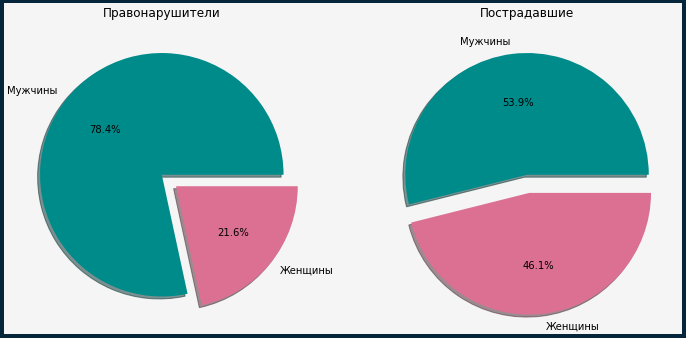

In [21]:
plt.figure(figsize=(12, 8), linewidth=8, edgecolor="#04253a") \
.set_facecolor(digclr)

ax = plt.subplot(1, 2, 1)
ax.set_title("Правонарушители")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')
ax.pie(offender_count,
       labels=["Мужчины", "Женщины"],
       colors=('darkcyan', 'palevioletred'),
       explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')

ax = plt.subplot(1, 2, 2)
ax.set_title("Пострадавшие")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')

ax.pie(victim_count,  labels=["Мужчины", "Женщины"],
       colors=('darkcyan', 'palevioletred'),
      explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')

plt.show()

**Вывод:**
> Мужчины чаще замешаны в преступлениях (в качестве жертвы или правонарушителя).

> Женщины являются преступникм лишь в четверти случаев правонарушения.

> Среди пострадавших процент мужчин и женщин отличается незначительно.



## Был ли найден нападавший?

Определим процентное отношение случаев, в которых был найден нападавший.

Создадим функцию для замены номера категории на её название

In [22]:
def off_found_group(x):
  if x == 1.0: return "Нарушитель найден"
  else: return "Нарушитель не найден"

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [23]:
offender_found = victims['victim_is_offender_found'].dropna() \
.apply(off_found_group)

print("Выборка содержит", len(offender_found), "строк")

Выборка содержит 3001 строк


In [24]:
offender_found_count = victims['victim_is_offender_found'].dropna() \
.apply(off_found_group).value_counts(1)

print("Был ли найден преступник?")
for i in range(len(offender_found_count)):
  print("{:<20} - {:.3f}%".format(offender_found_count.index[i],
                              offender_found_count[i] * 100))

Был ли найден преступник?
Нарушитель не найден - 73.775%
Нарушитель найден    - 26.225%


Построим по полученным значениям график.

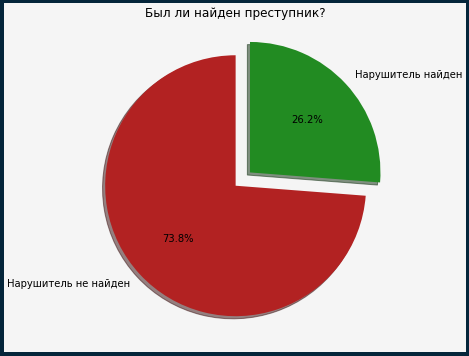

In [25]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(digclr)

plt.pie(offender_found_count.tolist(), labels=offender_found_count.index,
        colors=('firebrick', 'forestgreen'), explode=(0, 0.15),
        shadow=True, startangle=90, autopct='%1.1f%%')

plt.title('Был ли найден преступник?')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> По данным опроса, в трёх из четырёх случаев преступления правонарушитель остаётся не найденным.

## Была ли необходима медицинская помощь?

Определим процентное отношение пострадавших от физического насилия, которым впоследствии была необходима медицинская помощь.

Создадим функцию для замены номера категории на её название

In [26]:
def is_seeking_medical_help(x):
   if x == 1.0:
     return 'Нуждался в помощи'
   else:
     return 'Не нуждался в помощи'

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [27]:
med_help = victims['crime_is_seeking_medical_help'] \
                [victims['crime_is_violent_damage'] == 1.0] \
              .apply(is_seeking_medical_help)

print("Выборка содержит", len(med_help), "строк")

Выборка содержит 350 строк


Посчитаем процентное содержание каждой категории в выборке

In [28]:
med_help_perc = med_help.value_counts(1).sort_values()

print("Была ли необходима мед. помощь?:")
for i in range(len(med_help_perc)):
  print("{:<20} - {:.3f}%".format(med_help_perc.index[i],
                                  med_help_perc[i] * 100))

Была ли необходима мед. помощь?:
Нуждался в помощи    - 48.286%
Не нуждался в помощи - 51.714%


Построим по полученным значениям график.

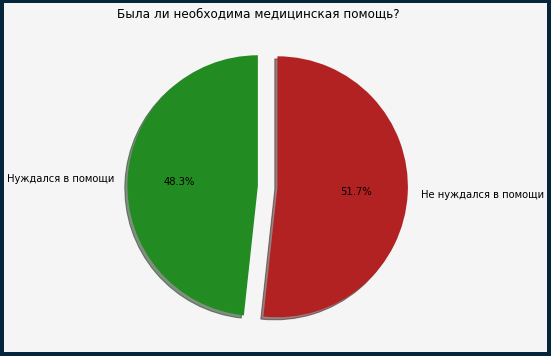

In [29]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(digclr)

plt.pie(med_help_perc, labels=med_help_perc.index,
        colors=('forestgreen', 'firebrick'), explode=(0, 0.15),
        shadow=True, startangle=90, autopct='%1.1f%%')

plt.title('Была ли необходима медицинская помощь?')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> Почти половине случаев физического насилия пострадавший от преступления нуждался в медицинской помощи.

## Был ли нападавший при исполнении?

Определим случаи, в которых нападавших был при исполнении. Также определим вид занятости, если преступник был при исполнении.

Создадим функцию для замены номера категории на её название

In [30]:
def offender_group(x):
  d = {1.0: 'Правоприменитель',
       2.0: 'Представитель власти', 
       3.0: 'Военный', 
       4.0: 'Сотрудник коммерческой организации', 
       5.0: 'Не при исполнении'}
  return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [31]:
offender_on_duty = victims['offender_is_on_duty'] \
[victims['offender_is_on_duty'] != 6.0].dropna().apply(offender_group)

print("Выборка содержит", len(offender_on_duty), "строк")

Выборка содержит 1215 строк


Посчитаем процентное отношение категорий в выборке

In [32]:
offender_on_duty_group = offender_on_duty.value_counts(1).sort_values()
print("Был ли преступник при исполнении?:")
for i in range(len(offender_on_duty_group)):
  print("{:<35} - {:.3f}%".format(offender_on_duty_group.index[i],
                                  offender_on_duty_group[i] * 100))
  

Был ли преступник при исполнении?:
Военный                             - 0.658%
Представитель власти                - 2.551%
Правоприменитель                    - 3.951%
Сотрудник коммерческой организации  - 15.391%
Не при исполнении                   - 77.449%


Создадим две переменные, в первую поместим процентное соотношение видов занятости среди нападавших при исполнении, во вторую процентное соотношение нападавших при исполнении к нападавшим не при исполнении.

In [33]:
sum_type_duty = offender_on_duty[offender_on_duty != "Не при исполнении"]\
                                            .value_counts(1).sort_values()

sum_on_duty = [sum(offender_on_duty_group[:4]), offender_on_duty_group[4]]

print("Был ли преступник при исполнении?:")
print("При исполнении    - {:.3f}%\nНе при исполнении - {:.3f}%\n" \
      .format(sum_on_duty[0] * 100, sum_on_duty[1] * 100))

print("Соотношение видов занятости среди нападавших при исполнении:")
for i in range(len(sum_type_duty)):
  print("{:<35} - {:.3f}%".format(sum_type_duty.index[i],
                                  sum_type_duty[i] * 100))

Был ли преступник при исполнении?:
При исполнении    - 22.551%
Не при исполнении - 77.449%

Соотношение видов занятости среди нападавших при исполнении:
Военный                             - 2.920%
Представитель власти                - 11.314%
Правоприменитель                    - 17.518%
Сотрудник коммерческой организации  - 68.248%


Построим по полученным значениям график.

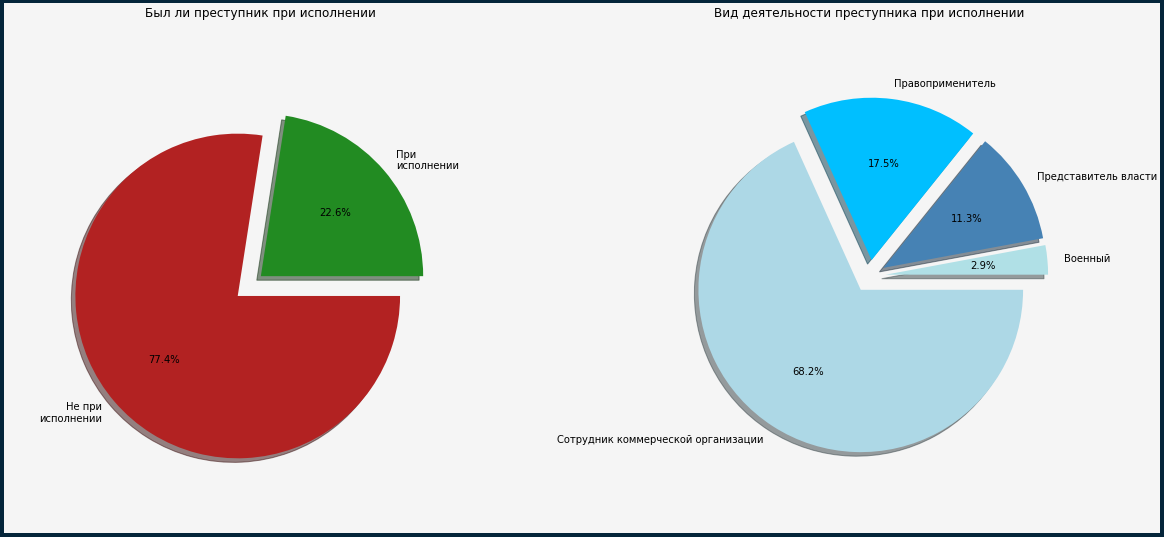

In [34]:
# Красивые графики
plt.figure(figsize=(20, 12), linewidth=8, edgecolor="#04253a") \
.set_facecolor(digclr)

ax = plt.subplot(1, 2, 1)
ax.set_title("Был ли преступник при исполнении")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')

ax.pie(sum_on_duty,
       labels=["При\nисполнении", "Не при\nисполнении"], radius=0.8,
       colors=('forestgreen', 'firebrick'), explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')

ax = plt.subplot(1, 2, 2)
ax.set_title("Вид деятельности преступника при исполнении")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')

ax.pie(sum_type_duty, labels=sum_type_duty.index,
       radius=0.8, colors=colors,
       explode=(0.08, 0.08, 0.08, 0.08),
       shadow=True, autopct='%1.1f%%')

plt.show()

**Вывод:**
> Более 20% злоумышленников находились при исполнении своих обязанностей

> Большая часть правонарушителей, находящихся при исполнении обязанностей, относится к категории сотрудников коммерчесих организаций

> Более 30% правонарушителей являются чиновниками (госслужащими), среди них большую часть преступлений совершают правоприменители (17.5%), меньшую – военные (2.9%), а представители власти, по данным опроса, занимают 11.3% от всех правонарушителей при исполнении.

## Анализ частоты видов преступлений

Определим процентное отношение частоты каждого преступления.

Создадим функцию для замены номера категории на её название

In [35]:
def crime_type_rename(x):
  dic = {1.0: 'Нападение', 
         2.0: 'Угрозы ', 
         3.0: 'Грабеж и разбой ', 
         4.0: 'Кража', 
         5.0: 'Мошенничество', 
         6.0: 'Мошенничество', 
         7.0: 'Прочее'}
  return dic[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [36]:
crime_type = victims['crime_type'].drop(
    victims['crime_type'][victims['crime_type'] == 8.0].index) \
    .apply(crime_type_rename)

print("Выборка содержит", len(crime_type), "строк")

Выборка содержит 2422 строк


Посчитаем процентное отношение каждой категории в выборке

In [37]:
crime_type_perc = crime_type.value_counts(1)

print("Вид преступления:")
for i in range(len(crime_type_perc)):
  print("{:<16} - {:.3f}%".format(crime_type_perc.index[i],
                                  crime_type_perc[i] * 100))


Вид преступления:
Мошенничество    - 40.173%
Кража            - 25.021%
Грабеж и разбой  - 12.428%
Угрозы           - 8.629%
Нападение        - 8.051%
Прочее           - 5.698%


Построим по полученным значениям график

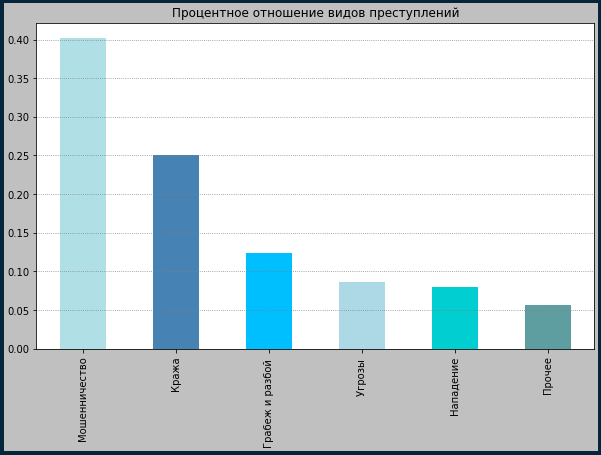

In [38]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

crime_type_perc.plot.bar(color=colors)
plt.title('Процентное отношение видов преступлений')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> Наиболее частый вид преступления по данным опроса – мошенничество (почти половина от всех преступлений)

> Кражи (тайные хищения) в 2 раза распространеннее грабежей и разбоев (насильственных хищений)

> Количество угроз незначительно больше количества нападений

> Прочие правонарушения занимают чуть более 5% от всех преступлений

> Таким образом, по данным опроса, мы можем сделать вывод, что преступления, подразумевающие использование физической силы, совершаются реже, чем преступления без насилия.

## Анализ влияния возраста на подверженность преступлениям

Определим зависимость возраста человека и подверженности преступлению. 

Создадим функцию для замены номера категории на её название

In [39]:
def age_group(x):
  if 18 <= x <= 24:
    return '18-24'
  elif 25 <= x <= 34:
    return '25-34'
  elif 35 <= x <= 44:
    return '35-44'
  elif 45 <= x <= 54:
    return '45-54'
  elif 55 <= x <= 64:
    return '55-64'
  elif x >= 65:
    return '65+'

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [40]:
resp_age = victims['resp_age'].apply(age_group)

print("Выборка содержит", len(resp_age), "строк")

Выборка содержит 3001 строк


Посчитаем процентное содержание каждой категории в выборке

In [41]:
group_resp_age = resp_age.value_counts(1).sort_index()

print("Среди пострадавших:")
for i in range(len(group_resp_age)):
  print("{:^5} лет - {:.3f}%".format(group_resp_age.index[i],
                                  group_resp_age[i] * 100))

Среди пострадавших:
18-24 лет - 11.096%
25-34 лет - 28.391%
35-44 лет - 21.593%
45-54 лет - 15.095%
55-64 лет - 13.462%
 65+  лет - 10.363%


Построим по полученным значениям график.

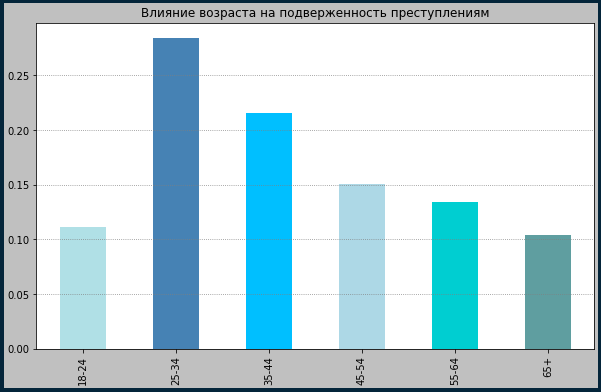

In [42]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)
group_resp_age.plot.bar(color=colors)

plt.title('Влияние возраста на подверженность преступлениям')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> Наименее подверженны преступлениям возрастные категории "18-24" и "65+".

> Наиболее подвержены преступлениям лица 25-34 лет, далее процент жертв плавно уменьшается

Попробуем найти зависимость типа преступления от возраста. Для этого создадим выборки по каждой возрастной категории и посчитаем процент каждого вида преступлений среди полученных выборок

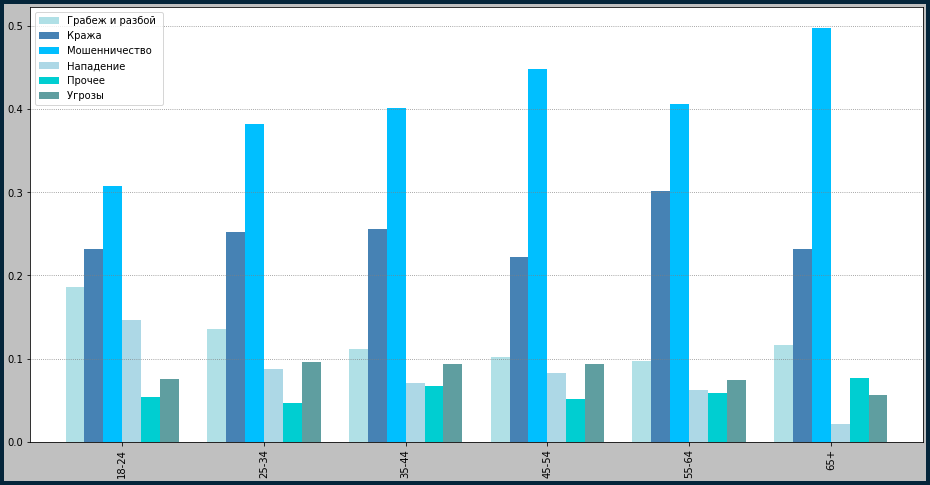

In [43]:
victims['resp_age_group'] = victims['resp_age'].apply(age_group)

crime_age = pd.concat([victims['crime_type'].drop(victims['crime_type']
                        [victims['crime_type'] == 8.0].index),
                        victims['resp_age_group']], axis=1).dropna()

age_lst = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

s = []
for i in age_lst:
  s.append(crime_age['crime_type'][crime_age['resp_age_group'] == i] \
     .apply(crime_type_rename).value_counts(1).sort_index())

fp = pd.DataFrame(s,
              index=age_lst,
              columns=s[0].index)

fig, ax = plt.subplots(linewidth=8, edgecolor="#04253a")

ax.set_facecolor('white')
fig.set_figwidth(16)    #  ширина Figure
fig.set_figheight(8)    #  высота Figure
fig.set_facecolor(pltclr)

fp.plot.bar(color=colors, ax=ax, width=0.8)

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.show()


**Вывод:**


> Пожилые люди чаще других становятся жертвами мошенничества, в то время как молодые – реже всего. Вероятно, это связанно с совершенствованием и цифровизацией методов мошенничества, что подвергает лиц, не обладающих достаточной цифровой грамостностью, наибольшим рискам со стороны мошенников.

> Молодые люди чаще остальных становятся жертвами грабежей и разбоев, далее процент плавно уменьшается и слегка возрастает у лиц возраста "65+".

> Наиболее подвержены кражам лица категории "55-64", остальные категории по процентному отношению отличаются незначительно.

> Наименее подвержены угрозам возрастные группы "18-24" и "65+", остальные категории по процентному отношению отличаются незначительно.

> Жертвами краж чаще всего становятся люди возрастной категории "55-64". Возможно, это связанно с тем, что люди к данному периоду жизни успевают уже материально обеспеченны и имеют накопления к выходу на пенсию, чем вызывают интерес преступников.

> Прочим преступлениям больше всего подвержены пенсионеры.





## Анализ влияния дохода на подверженность преступлениям

Для начала найдем процентное отношение каждого вида дохода среди пострадавших.

Создадим функцию для замены номера категории на её название

In [44]:
def income(x):
  d = {1.0: "Бедность",
       2.0: "Низкий",
       3.0: "Средний",
       4.0: "Высокий",
       5.0: "Очень высокий"}
  return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [45]:
resp_income = victims['resp_income'].dropna() \
                    .sort_values().apply(income)

print("Выборка содержит", len(resp_income), "строк")

Выборка содержит 2910 строк


Посчитаем процентное содержание каждой категории в выборке

In [46]:
group_resp_income = resp_income.value_counts(1). \
                    reindex(resp_income.unique())

print("Среди пострадавших:")
for i in range(len(group_resp_income)):
  print("{:<13} - {:.3f}%".format(group_resp_income.index[i],
                                  group_resp_income[i] * 100))


Среди пострадавших:
Бедность      - 10.103%
Низкий        - 27.491%
Средний       - 35.739%
Высокий       - 18.969%
Очень высокий - 7.698%


Построим по полученным значениям график.

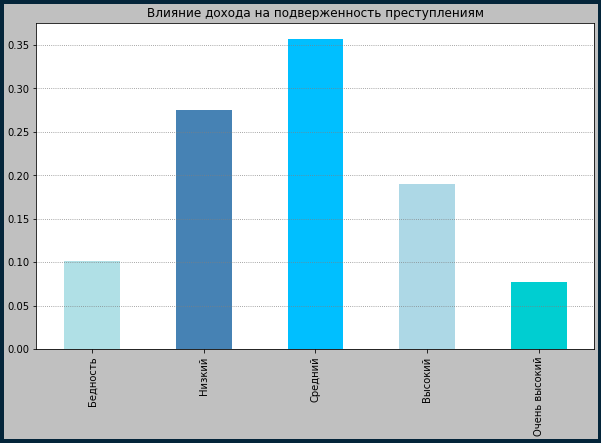

In [47]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

group_resp_income.plot.bar(color=colors)

plt.title('Влияние дохода на подверженность преступлениям')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод**:


> Распределение процентного отношения подверженности преступлениям среди разных уровней дохода близко к нормальному распределению.

> Логично предположить, что бедные менее подвержены преступлениям из-за отсутствия материальных средств и имущества, а люди с очень высоким уровнем дохода – в силу того, что их уровень достатка позволяет позаботится о безопасности своих ценностей.


Определим зависимость между уровнем дохода и типом преступления. Для этого создадим выборки по каждому уровню дохода и найдем процентное соотношение видов преступлений среди полученных выборок

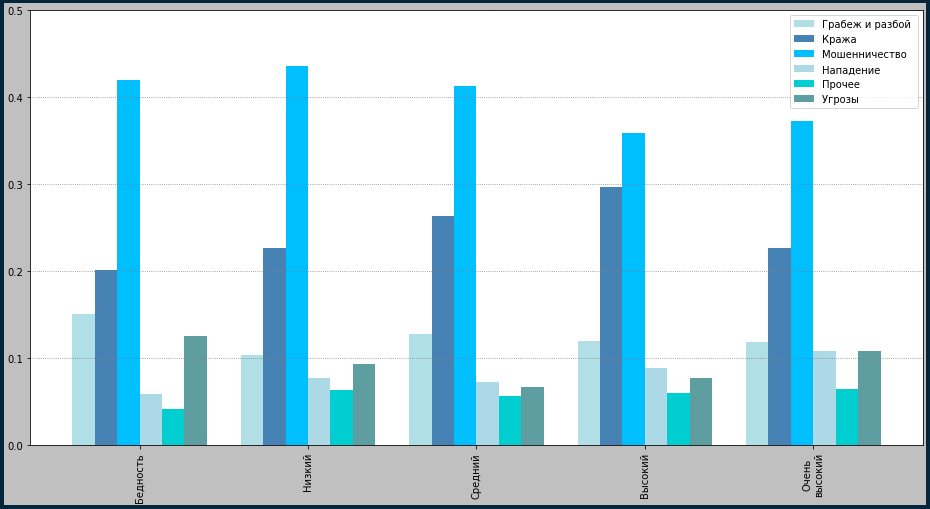

In [48]:
#Графики процента вида преступления для каждого уровня доходов

crime_income = pd.concat([victims['crime_type'].drop(victims['crime_type']
                        [victims['crime_type'] == 8.0].index),
                        victims['resp_income']], axis=1).dropna()

s = []
for i in range(1, 6):
  s.append(crime_income[crime_income['resp_income'] == i]['crime_type']
           .apply(crime_type_rename).value_counts(1).sort_index())
  
crime_type_lst = ["Бедность", "Низкий", "Средний", "Высокий", "Очень\nвысокий"]

fp = pd.DataFrame(s,
              index=crime_type_lst,
              columns=s[0].index)

fig, ax = plt.subplots(linewidth=8, edgecolor="#04253a")

ax.set_facecolor('white')
fig.set_figwidth(16)    #  ширина Figure
fig.set_figheight(8)    #  высота Figure
fig.set_facecolor(pltclr)

fp.plot.bar(color=colors, ax=ax, width=0.8)

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.ylim(top=0.5)

plt.show()

**Вывод:**

> Среди всех уровней дохода наиболее распространённым видом преступления является мошенничество. Наиболее подвержены люди с низкими и очень низкими доходами.

> Бедные больше других подвержены грабежам и разбоям, угрозам, но меньше всех – нападениям и прочим видам преступлений.

> Люди с очень высоким уровнем дохода часто становятся жертвами угроз, нападений, грабежей и разбоев, что связанно с повышенной заинтересованностью преступников в заполучении чужих материальных ценностей.

> Высокий класс больше других подвержен кражам.



##Анализ влияния образования на подверженность преступлениям


Для начала найдем процентное отношение каждого вида образования среди пострадавших.

Создадим функцию для замены номера категории на её название

In [49]:
def resp_edu_group(x):
  d = {1: "Полное среднее и ниже",
       2: "Среднее спец-ное/техническое\nили нач-ное профес-ное",
       3: "Высшее и незаконченное высшее"}
  return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [50]:
resp_edu = victims["resp_edu"].dropna().sort_values() \
                              .apply(resp_edu_group)

print("Выборка содержит", len(resp_edu), "строк")

Выборка содержит 3001 строк


Посчитаем процентное содержание каждой категории в выборке

In [51]:
group_resp_edu = resp_edu.value_counts(1). \
                    reindex(resp_edu.unique())

print("Среди пострадавших:")
for i in range(len(group_resp_edu)):
  print("{:<13} - {:.3f}%".format(group_resp_edu.index[i],
                                  group_resp_edu[i] * 100))

Среди пострадавших:
Полное среднее и ниже - 18.094%
Среднее спец-ное/техническое
или нач-ное профес-ное - 35.322%
Высшее и незаконченное высшее - 46.584%


Построим по полученным значениям график.

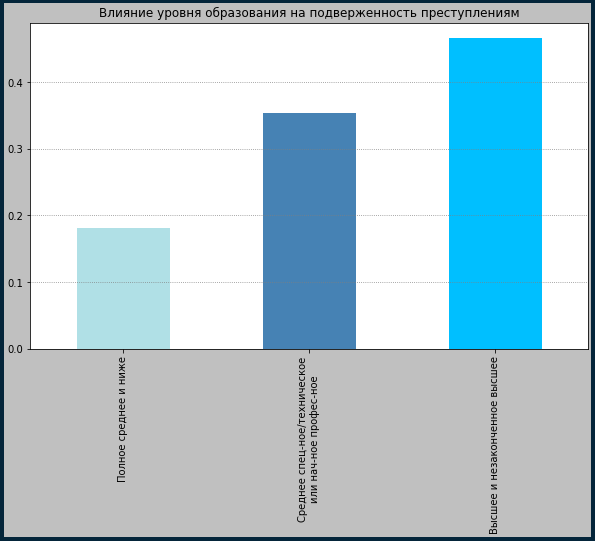

In [52]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

group_resp_edu.plot.bar(color=colors)

plt.title('Влияние уровня образования на подверженность преступлениям')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**

> Почти половина пострадавших респондентов имеет высшее или незаконченное высшее образование

> Чуть больше трети пострадавших респондентов имеет среднее спец-ное/техническое или нач-ное профес-ное образование

> Менее четверти пострадавших респондентов имеет полное среднее образование и ниже

*Данное распределение объясняется тем, что люди категории 18-24 имеют более низкий уровень образования и менее подвержены преступлениям, чем люди более старших возрастов, которые соответственно имеют более высокий уровень образования*

Определим зависимость между образования и типом преступления. Для этого создадим выборки по каждому виду образования и найдем процентное соотношение видов преступлений среди полученных выборок

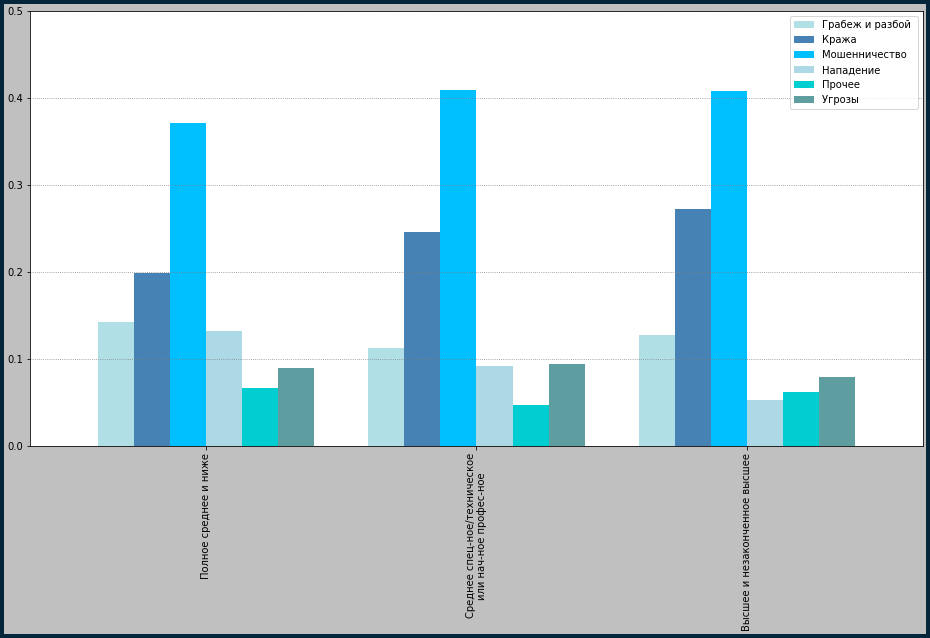

In [53]:
#Графики процента вида преступления для каждого уровня доходов

crime_edu = pd.concat([victims['crime_type'].drop(victims['crime_type']
                        [victims['crime_type'] == 8.0].index),
                        victims['resp_edu']], axis=1).dropna()

s = []
for i in range(1, 4):
  s.append(crime_edu[crime_edu['resp_edu'] == i]['crime_type']
           .apply(crime_type_rename).value_counts(1).sort_index())
  
edu_lst = ["Полное среднее и ниже",
           "Среднее спец-ное/техническое\nили нач-ное профес-ное",
           "Высшее и незаконченное высшее"]

fp = pd.DataFrame(s,
              index=edu_lst,
              columns=s[0].index)

fig, ax = plt.subplots(linewidth=8, edgecolor="#04253a")

ax.set_facecolor('white')
fig.set_figwidth(16)    #  ширина Figure
fig.set_figheight(8)    #  высота Figure
fig.set_facecolor(pltclr)

fp.plot.bar(color=colors, ax=ax, width=0.8)

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.ylim(top=0.5)

plt.show()

**Вывод:**

> По мере роста уровня образования респондентов растет уровень краж, что, возможно, связано с тем, что более высокообразованные люди имеют более высокооплачиваемую работу и, следовательно, обладают материальными благами, что делает их более вероятными жертвами покушений на кражи.

> По мере роста уровня образования респондентов падает количество совершаемых в их сторону нападений.

> Уровни остальных преступлений не имеют прямых зависимостей от уровня образования опрошенного.


## Анализ скорости реагирования правоохранителей



Определим скорость реагирования правоохранительных органов на преступления.

Создадим функцию для замены номера категории на её название

In [54]:
def reaction_time_group(x):
  d = {1.0: "Менее чем 30 минут",
       2.0: "Менее чем 1 час",
       3.0: "Менее чем 3 часа",
       4.0: "Менее чем 6 часов",
       5.0: "Менее чем 12 часов",
       6.0: "Не приехали"}
  return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [55]:
police_react = victims['victim_police_reaction_time'] \
              .dropna().sort_values().drop(
              victims['victim_police_reaction_time']
              [victims['victim_police_reaction_time'] == 7.0].index) \
              .apply(reaction_time_group)

print("Выборка содержит", len(police_react), "строк")

Выборка содержит 422 строк


Посчитаем процентное содержание каждой категории в выборке

In [56]:
group_police_reaction = police_react.value_counts(1) \
                        .reindex(police_react.unique())

print("Полиция среагировала:")
for i in range(len(group_police_reaction)):
  print("{:<18} - {:.3f}%".format(group_police_reaction.index[i],
                                  group_police_reaction[i] * 100))


Полиция среагировала:
Менее чем 30 минут - 50.000%
Менее чем 1 час    - 25.592%
Менее чем 3 часа   - 10.427%
Менее чем 6 часов  - 1.659%
Менее чем 12 часов - 2.844%
Не приехали        - 9.479%


Построим по полученным значениям график.


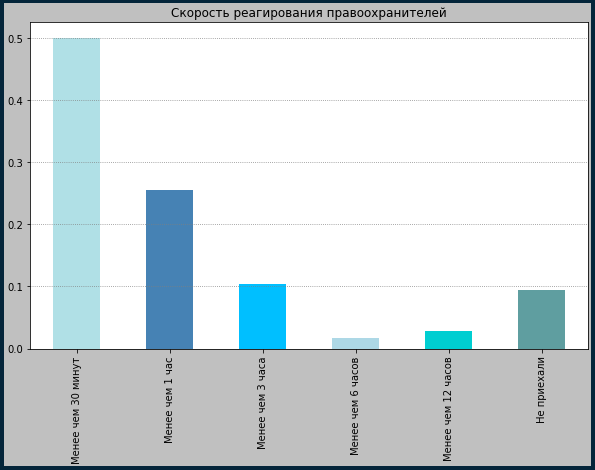

In [57]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

group_police_reaction.plot.bar(color=colors)

plt.title('Скорость реагирования правоохранителей')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> В половине случаев правоохранители реагируют на вызов с должной скоростью (меньше 30 минут)

> В четверти случаев полицейские приезжают менее чем за час.

> В 10% случаев полицейские приезжают в течение трех часов.

> Почти в каждом десятом случае полицейские не приезжают по вызову

## Анализ материального ущерба пострадавших

Проанализируем материальный ущерб пострадавшим, определим медианное и среднее значение материального ущерба.

Создадим выборку, содержащую материальный ущерб жертв преступлений и посчитаем её размер

In [58]:
damage_rub = victims['victim_damage_rub'] \
            [victims['victim_damage_rub'] != 0].dropna() 

damage_rub.rename("damage")

0           300.0
1         80000.0
2          3000.0
3          7000.0
5          2000.0
           ...   
16778     10000.0
16788      1000.0
16803     12000.0
16807    124000.0
16814      1500.0
Name: damage, Length: 2007, dtype: float64

Теперь посчитаем средний и медианный материальные ущербы

In [59]:
damage_median = damage_rub.median()

damage_mean = damage_rub.mean()

print("Медиана материального ушерба - {} рублей"
        .format(int(damage_median)))

print("Среднее материального ушерба - {} рублей"
        .format(int(damage_mean)))

Медиана материального ушерба - 12000 рублей
Среднее материального ушерба - 3116267 рублей


Мы можем заметить что среднее значение значительно отличается от медианного, возможно это происходит из-за выбросов в данных. Чтобы подтвердить наше предположение построим "ящик с усами".

<AxesSubplot:>

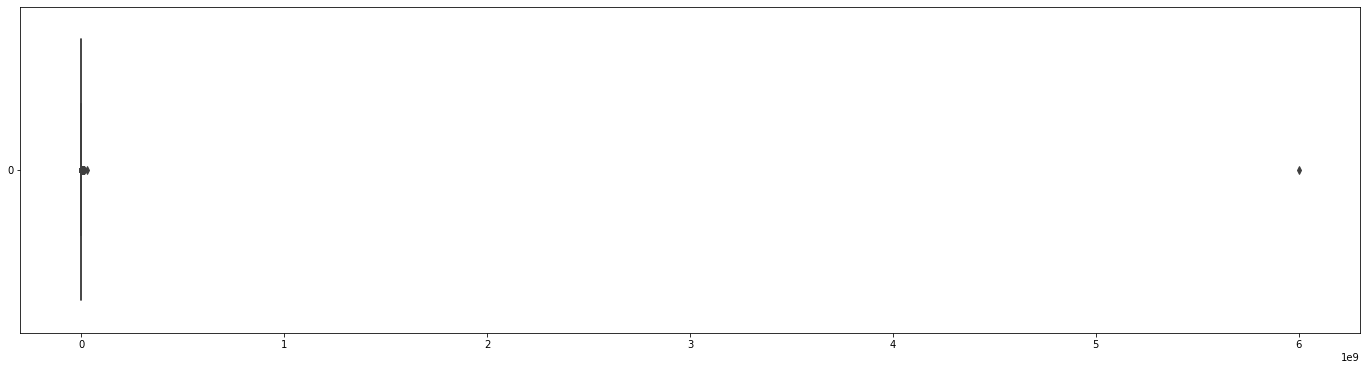

In [60]:
fig, ax = plt.subplots(figsize=(24, 6))
sns.boxplot(data=damage_rub, orient="h", ax=ax)

Как мы видим выбросы присутствуют(ромбовидные точки на графике).

Попробуем избавиться от выбросов, используя правило трех сигм, применив формулу:

$$z = \frac{x-\mu}{\sigma}$$

где z - Z-оценка

x - значение

μ - медиана.

σ - среднеквадратическое отклонение

Мы удалим все значения чья Z-оценка будет больше 2.

In [61]:
print("До исключения выбросов выборка содержит", len(damage_rub), "строк")

damage_rub = damage_rub[(damage_rub * damage_median
                        / np.std(damage_rub)) < 3]

print("После исключения выбросов выборка содержит", len(damage_rub), "строк")

До исключения выбросов выборка содержит 2007 строк
После исключения выбросов выборка содержит 1452 строк


Снова построим "ящик с усами", чтобы убедиться в том, что выбросы были исключены.

<AxesSubplot:>

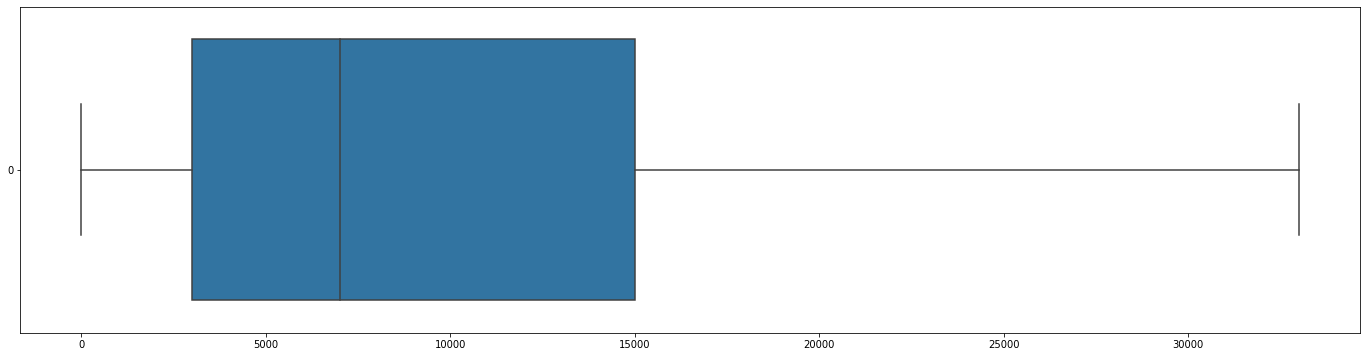

In [62]:
fig, ax = plt.subplots(figsize=(24, 6))
sns.boxplot(data=damage_rub, orient="h", ax=ax)

Как мы видим, выбросы были успешно удалены.

Повторим вычисления среднего и медианы

In [63]:
damage_median_new = damage_rub.median()

damage_mean_new = damage_rub.mean()

print("Медиана материального ушерба после исключения выбросов - {} рублей"
        .format(int(damage_median_new)))

print("Среднее материального ушерба после исключения выбросов - {} рублей"
        .format(int(damage_mean_new)))

Медиана материального ушерба после исключения выбросов - 7000 рублей
Среднее материального ушерба после исключения выбросов - 9818 рублей


**Вывод:**
> Существуют случаи, когда ущерб в результате преступления значительно превышает ущерб в большинстве других случаев. Из-за значительного влияния на среднее и медианное значение, данные случаи были исключены.

> Медианный материальный ущерб после исключения выбросов данных, полученный пострадавшими в результате преступления, составляет 7 000 рублей.

> Средний материальный ущерб после исключения выбросов данных, полученный пострадавшими в результате преступления, составляет 9 818 рублей.

## Анализ зависимости вида преступлений от времени суток

Определим процентную зависимость количества совершаемых преступлений от времени суток.

Создадим функцию для замены номера категории на её название

In [64]:
def if_day(x):
  if x == 1.0:
    return 'День'
  else:
    return 'Ночь'

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [65]:
victims_time = victims['crime_is_daytime'].dropna() \
.apply(if_day)

print("Выборка содержит", len(victims_time), "строк")

Выборка содержит 3001 строк


Посчитаем процентное содержание каждой категории в выборке

In [66]:
victims_time_count = victims_time.value_counts(1)

print("Время суток в момент совершения преступления:")
for i in range(len(victims_time_count)):
  print("{} - {:.3f}%".format(victims_time_count.index[i],
                                  victims_time_count[i] * 100))

Время суток в момент совершения преступления:
День - 65.178%
Ночь - 34.822%


Построим по полученным значениям график.

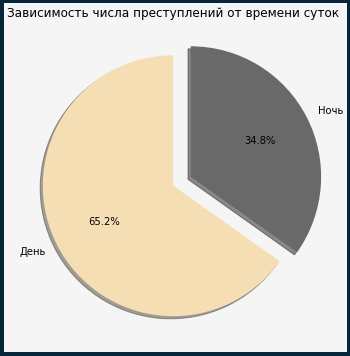

In [67]:
#Красивые графики
ax = plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a")
ax.set_facecolor(digclr)


plt.pie(victims_time_count, labels=victims_time_count.index, colors=('wheat','dimgray'),
        explode=(0, 0.15), shadow=True, startangle=90, autopct='%1.1f%%')

plt.title('Зависимость числа преступлений от времени суток')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> Большая часть преступлений совершается в дневное время суток.

Затем попробуем найти зависимость между определенным видом преступления и временем суток. Для этого создадим выборки по каждому виду преступлений и посчитаем процентное соотношение преступлений ночью и преступлений днем

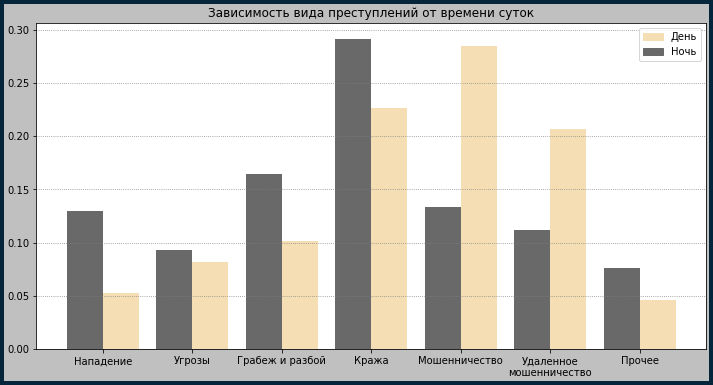

In [68]:
crimes = victims['crime_type'][victims['crime_type'] != 8.0]

daytime_crime = crimes[victims['crime_is_daytime'] == 1.0] \
.value_counts(1).sort_index().tolist()

nighttime_crime = crimes[victims['crime_is_daytime'] == 0.0] \
.value_counts(1).sort_index().tolist()

# Красивые графики
tick_names = ['Нападение',
              'Угрозы',
              'Грабеж и разбой',
              'Кража',
              'Мошенничество',
              'Удаленное\nмошенничество',
              'Прочее'] 

fig, ax = plt.subplots(linewidth=8, edgecolor="#04253a")

ax.bar(tick_names, daytime_crime, align='edge',
       width=0.4, color='wheat')
ax.bar(tick_names, nighttime_crime, align='edge',
       width=-0.4, color='dimgray')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.title('Зависимость вида преступлений от времени суток')

day_patch = mpatches.Patch(color='wheat', label='День')
night_patch = mpatches.Patch(color='dimgray', label='Ночь')
ax.legend(handles=[day_patch, night_patch])

ax.set_facecolor('white')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
fig.set_facecolor(pltclr)

**Вывод:**
> Наиболее серьезные преступления, такие как нападения, угрозы, грабежи и разбои, кражи, совершаются в большинстве случаев в тёмное время суток

> Преступления, связанные с мошенничеством и удаленным мошенничеством, чаще всего совершаются днём

> Таким образом, несмотря на то, что большинство преступлений осуществляется днём, наиболее тяжкие из них осуществляются ночью. Процент дневных преступлений больше, поскольку значительная часть от них занимает мошенничество, осуществляемое в большинстве случаев в светлое время суток.

# Классификационная модель
##### Исходя из полученных нами данных в результате исследования зависимости влияния социально-демографических характеристик человека на его подверженность преступлению, было принято решение построить классификационную модель, предсказывающую вероятность стать жертвой преступления (целевой признак – **resp_is_crime_victim**) исходя из 4 категориальных признаков:
*   **resp_is_male** – пол жертвы преступления
*   **resp_age** – возрастная категория, к которой относится респондент
*   **resp_edu** – уровень образования респондента
*   **resp_incom** – уровеень дохода опрошенного

Для этого была выбрана библиотека **CatBoost** – открытая программная библиотека, разработанная компанией **Яндекс** и реализующая уникальный патентованный алгоритм построения моделей машинного обучения, использующий одну из оригинальных схем градиентного бустинга, включающая в себя классификационную модель **CatBoostClassifier**.



In [69]:
from sklearn.model_selection import train_test_split

forcatbst = df[["resp_is_male", "resp_age", "resp_edu", "resp_income","resp_is_crime_victim"]]

train_cat, test_cat = train_test_split(forcatbst, train_size=0.75, random_state=42)

train_cat.fillna(-999, inplace=True)
test_cat.fillna(-999, inplace=True)

In [70]:
X = train_cat.drop("resp_is_crime_victim", axis=1)
y = train_cat.resp_is_crime_victim

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = test_cat

In [72]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [73]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    eval_metric='Accuracy',
    random_seed=69,
    logging_level='Silent',
    use_best_model=True,
    iterations=202,
    boosting_type='Ordered'
)

In [74]:
model = model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [75]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [76]:
validation_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)
eval_metrics = model.eval_metrics(validation_pool, ['Accuracy'], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [77]:
print('Precise validation accuracy score: {:.3f}%'.format(np.max(cv_data['test-Accuracy-mean']) * 100))

Precise validation accuracy score: 82.407%
